In [91]:
import arrow
#import datetime as dt

#import pandas as pd
#from pathlib import Path
#import xarray as xr
import yaml

#from salishsea_tools import rivertools
#from salishsea_tools import river_202108 as rivers

from DailyRiverFlows import make_runoff_files

#prop_dict_name ='river_202108'
#bathy_type = 'b202108'

In [92]:
config_file = 'nowcast.yaml'
with open(config_file, "r") as stream:
    config = yaml.safe_load(stream)
#config

In [93]:
# Date Range
dateneeded = arrow.get(2023, 2, 21)
print (dateneeded)

2023-02-21T00:00:00+00:00


In [94]:
make_runoff_files(dateneeded, config)

bute
no secondary
Homathko_Mouth
[[97.0915257]]
evi_n
no secondary
Salmon_Sayward
[[565.25543574]]
jervis
Clowhom_ClowhomLake
RobertsCreek
[[217.69422748]]
evi_s
no secondary
Englishman
[[180.9227418]]
howe
no secondary
Squamish_Brackendale
[[127.6401284]]
jdf
no secondary
SanJuan_PortRenfrew
[[621.71238903]]
skagit
Skagit_MountVernon
Snohomish_Monroe
[[1133.0656029]]
puget
Nisqually_McKenna
Greenwater_Greenwater
[[577.08733426]]
toba
Homathko_Mouth


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


[[106.45889729]]
fraser
Fraser
Nicomekl_Langley
[[1168.68661229]]
files read
/results/forcing/rivers/R202108Dailies_y2023m02d21.nc


def write_file(day, runoff):
    "keep it small and simple, runoff only"
    notebook = 'ProductionDailyRiverNCfile.ipynb'
    coords = {
        'x' : range(398),
        'y' : range(898),
        'time_counter' : [0],
    }
    var_attrs = {'units': 'kg m-2 s-1',
                      'long_name': 'runoff_flux'}
    
    year = day.year
    month = day.month
    day = day.day
    # set up filename to follow NEMO conventions
    filename = f'ncfiles/R202108Dailies_y{year}m{month:02}d{day:02}.nc'
    print (filename)
        
    netcdf_title = f'Rivers for y{year}m{month:02}d{day:02}'
    ds_attrs = {
        'acknowledgements':
            'Based on river fit',
        'creator_email':
            'sallen@eoas.ubc.ca',
        'creator_name':
            'Salish Sea MEOPAR Project Contributors',
        'creator_url':
            'https://salishsea-meopar-docs.readthedocs.org/',
        'institution':
            'UBC EOAS',
        'institution_fullname': (
            'Earth, Ocean & Atmospheric Sciences,'
            ' University of British Columbia'
        ),
        'title': netcdf_title,
        'notebook': notebook,
        'rivers_base': prop_dict_name,
        'summary': f'Daily Runoff for Bathymetry 202108',
        'history': (
            '[{}] File creation.'
            .format(dt.datetime.today().strftime('%Y-%m-%d'))
        )
        }
    runoffs = np.empty((1, runoff.shape[0], runoff.shape[1]))
    runoffs[0] = runoff

    da = xr.DataArray(
            data = runoffs,
            name='rorunoff',
            dims=('time_counter', 'y', 'x'),
            coords = coords,
            attrs = var_attrs)
    

    ds = xr.Dataset(
            data_vars={
            'rorunoff': da},
            coords = coords,
            attrs = ds_attrs
        )
    
    encoding = {var: {'zlib': True} for var in ds.data_vars}

    ds.to_netcdf(filename, unlimited_dims=('time_counter'),
            encoding=encoding,)


# Plotting and Checking #

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from salishsea_tools import nc_tools, viz_tools


In [96]:
bathy = xr.open_dataset('../../../grid/bathymetry_202108.nc')

In [97]:
imin, imax = 0, 898
jmin, jmax = 0, 394
jj = range(jmax)
ii = range(imax)
jjm, iim = np.meshgrid(jj, ii)

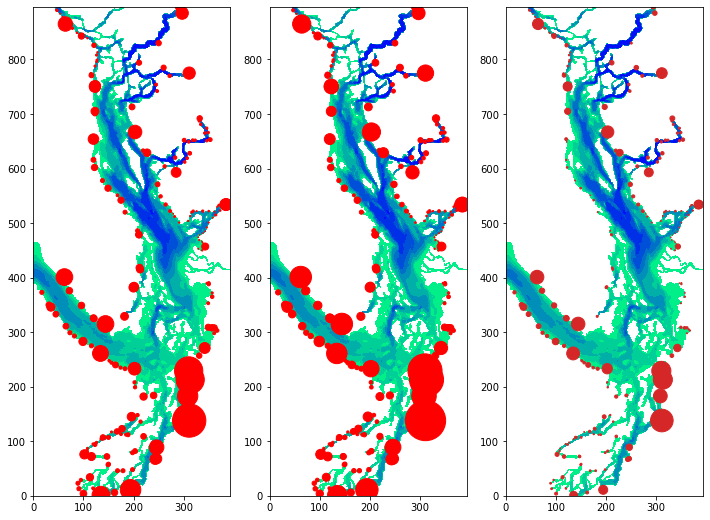

In [98]:
compare = xr.open_dataset(f'/results/forcing/rivers/R202108Dailies_y{dateneeded.year}m{dateneeded.month:02d}d{dateneeded.shift(days=-1).day:02d}.nc')
#compare = xr.open_dataset(f'/results/forcing/rivers/R202108Dailies_y2022m12d26.nc')
readitin = xr.open_dataset(f'/results/forcing/rivers/R202108Dailies_y{dateneeded.year}m{dateneeded.month:02d}d{dateneeded.day:02d}.nc')
fluxarray = np.array(readitin.rorunoff[0, :, :jmax])
climatearray = np.array(compare.rorunoff[0, :, :jmax])
fig, axs = plt.subplots(1, 3, figsize=(12, 9))
for ax in axs:
    ax.contourf(bathy.Bathymetry[imin:imax, jmin:jmax], cmap='winter_r')
      
axs[1].scatter(jjm[fluxarray>0], iim[fluxarray>0], s=fluxarray[fluxarray>0]*1000, color='r')
axs[0].scatter(jjm[climatearray>0], iim[climatearray>0], s=climatearray[climatearray>0]*1000, color='r')
axs[2].scatter(jjm[fluxarray>climatearray], iim[fluxarray>climatearray], 
               s=(fluxarray[fluxarray>climatearray]-climatearray[fluxarray>climatearray])*1000, color='tab:red')
axs[2].scatter(jjm[fluxarray<climatearray], iim[fluxarray<climatearray], 
               s=(-fluxarray[fluxarray<climatearray]+climatearray[fluxarray<climatearray])*1000, color='tab:blue', alpha=0.7)
                      
readitin.close()
compare.close()

In [99]:
dateneeded.shift(days=-1)

<Arrow [2023-02-20T00:00:00+00:00]>